In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings("ignore")

## Универсальные функции

Функции бывают:
*простые* -  выполняющие только простые действия например: замена пропуска значения на None, фильтрация выбросов
*составные* - состоят из простых функций

**простые**
 - determNoneValue - замена пропусков данных  модами
 - outliersData - функция фильтраци выбросов
 - replaceEmptySkipValue -  универсаклная функция замены пропуска  none
 
**составные**  
 - ordanaryValidValue - преобразование незвестного значения
 - permitValidValue -  фильтрация данных на валидных значениях + значение по умочанию
 - permitPositivValue - фильтрация положительных данных


## Первоначальный анализ данных
Тут я опишу какие закономрености я предварительно нашел:

- я не нашел в данных строковых данных, чтобы они отображадлись "криво" (неполно), поэтому не стал внедрнять функцию обработки стокровых столбцов (как функция fix_countries в примере )

- почти все числовые характириски являются по факту номинативными, но выраженными числами

- при обработке выбросов я заметил что у некоторых столбцов 25 процентиль равен 75 процентилю, в этом случае я не проводил фильтрацию данных по выбросам (данные надо удалять осторожно !!!!)

- логика обработки данных следующая

    - поиск пропусков и замена их на None
    - проверка того, что значение имеет валидное значение если невалидное значение замена его на None
    - заполнение пропусков в строках модами, самыми встречающими значениями
    - фильтрация выбросов
    
   такой подход позволил сохранить большинство значений в выборке (300 значений)
   


In [45]:
#  универсаклная функция замены пропуска  none
def replaceEmptySkipValue(data, columns):
    for column in columns:
        data[column] = data[column].apply(
            lambda x: None if pd.isnull(x) else (None if (x == 'nan' or str(x).strip() == '') else x))
    return data


# преобразование незвестного значения
def ordanaryValidValue(data, column, needOutliersData=False):
    data = replaceEmptySkipValue(data, [column])

    data = determNoneValue(data, column)

    if needOutliersData:
        data = outliersData(data, column)

    return data


# фильтрация данных на валидных значениях + значение по умочанию
def permitValidValue(data, column, premit_value, defaulVaue=None, needOutliersData=False):
    data = replaceEmptySkipValue(data, [column])

    data[column] = data[column].apply(lambda x: x if x in premit_value else defaulVaue)

    data = determNoneValue(data, column)
    if needOutliersData:
        data = outliersData(data, column)
    return data


# фильтрация положительных данных
def permitPositivValue(data, column, defaulVaue=None, needOutliersData=False):
    data = replaceEmptySkipValue(data, [column])
    data[column] = data[column].apply(lambda x: int(x) if x >= 0 else defaulVaue)

    data = determNoneValue(data, column)
    if needOutliersData:
        data = outliersData(data, column)

    return data


# замена пропусков данных модами
def determNoneValue(data, column):
    value_ = data[column].mode()[0]
    data.loc[:, column].fillna(value_, inplace=True)
    return data


#  функция фильтраци выбросов - если квинтили равны  -  не делаем выросы - распределени примено одинаково
def outliersData(data, column):
    quantile_3 = data[column].quantile(0.75)
    quantile_1 = data[column].quantile(0.25)
    if quantile_3 == quantile_1:
        return data

    IQR = quantile_3 - quantile_1
    column_min = quantile_1 - 1.5 * IQR
    column_max = quantile_3 + 1.5 * IQR

    data = data[data[column].between(column_min, column_max)]
    return data


## Загрузка данных:

In [46]:
student = pd.read_csv("C:/study/skillFactory/module_2/stud_math.xls")
#  неизвестный столбец - лишнеи данные не помешают 
student.rename(columns={'studytime, granular': 'granular'}, inplace=True)
student['granular'] = student['granular'] * (-1)

## Распределение признака для числовых переменных, устраним выбросы

**Age** - выбросов нет

<AxesSubplot:>

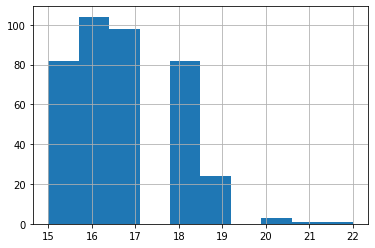

In [47]:
student = permitPositivValue(student, 'age')
student['age'].hist()

**granular** - неизвестный параметр

<AxesSubplot:>

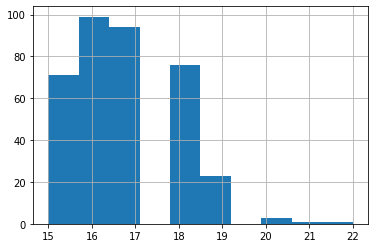

In [48]:
student = ordanaryValidValue(student, 'granular', needOutliersData=True)
student['age'].hist()

**Medu** - образование матери , доступыне значения (0,1,2,3,4)

<AxesSubplot:>

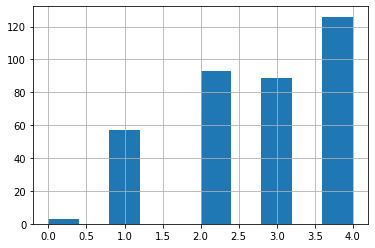

In [49]:
student = permitValidValue(student, 'Medu', [0, 1, 2, 3, 4], needOutliersData=True)
student['Medu'].hist()

**Fedu** - образование отца , доступыне значения (0,1,2,3,4)

<AxesSubplot:>

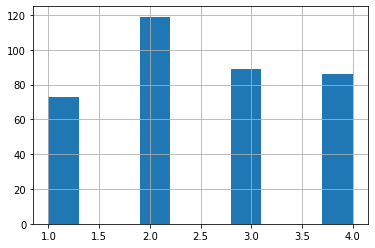

In [50]:
student = permitValidValue(student, 'Fedu', [0, 1, 2, 3, 4], needOutliersData=True)
student['Fedu'].hist()

**traveltime** - образование отца , доступыне значения (0,1,2,3,4)

<AxesSubplot:>

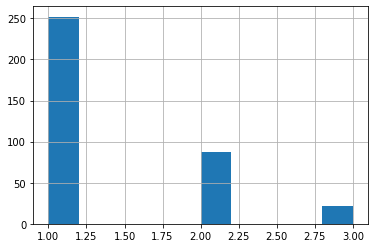

In [51]:
student = permitValidValue(student, 'traveltime', [1, 2, 3, 4], needOutliersData=True)
student['traveltime'].hist()

**studytime**  - время на учёбу помимо школы в неделю

<AxesSubplot:>

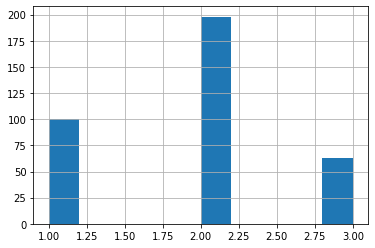

In [52]:
student = permitValidValue(student, 'studytime', [1, 2, 3, 4], needOutliersData=True)
student['studytime'].hist()

**failures**- количество внеучебных неудач

<AxesSubplot:>

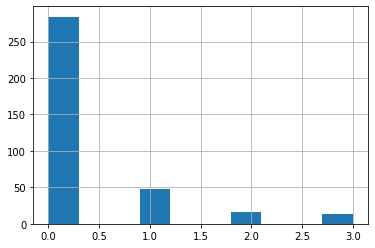

In [53]:
student = permitValidValue(student, 'failures', [1, 2, 3], defaulVaue=0, needOutliersData=True)
student['failures'].hist()

**famrel** - семейные отношения

<AxesSubplot:>

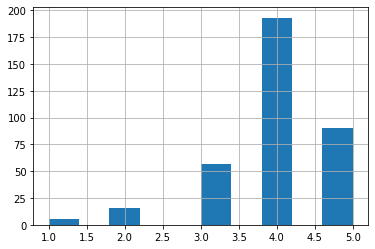

In [54]:
student = permitValidValue(student, 'famrel', [1, 2, 3, 4, 5], needOutliersData=True)
student['famrel'].hist()

**freetime** - свободное время после школы

<AxesSubplot:>

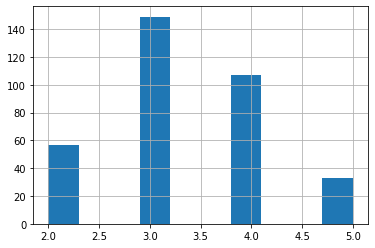

In [55]:
student = permitValidValue(student, 'freetime', [1, 2, 3, 4, 5], needOutliersData=True)
student['freetime'].hist()

**goout** - проведение времени с друзьями

<AxesSubplot:>

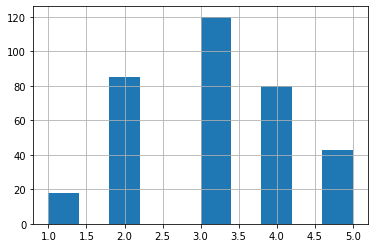

In [56]:
student = permitValidValue(student, 'goout', [1, 2, 3, 4, 5], needOutliersData=True)
student['goout'].hist()

**goout** - текущее состояние здоровья

<AxesSubplot:>

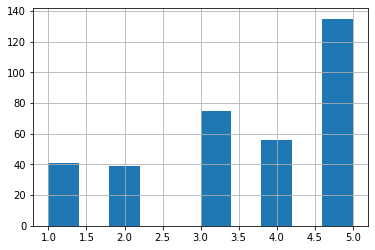

In [57]:
student = permitValidValue(student, 'health', [1, 2, 3, 4, 5], needOutliersData=True)
student['health'].hist()

**absences**  -  количество пропущенных занятий

<AxesSubplot:>

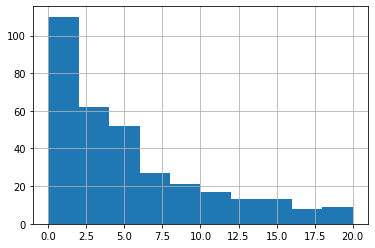

In [58]:
student = permitPositivValue(student, 'absences', needOutliersData=True)
student['absences'].hist()

**score** — баллы по госэкзамену по математике

<AxesSubplot:>

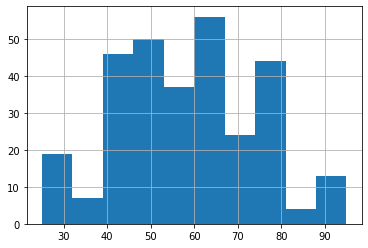

In [59]:
student = permitPositivValue(student, 'score', needOutliersData=True)
student['score'].hist()

## 2. Уникальных значений для номинативных переменных:

**sex** — пол ученика ('F' - женский, 'M' - мужской)

<AxesSubplot:>

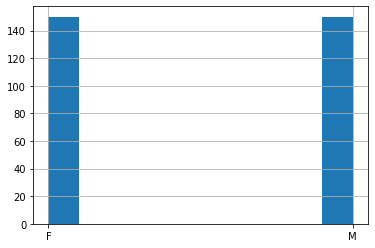

In [60]:
student = permitValidValue(student, 'sex', ['F', 'M'])
student['sex'].hist()

**address** — тип адреса ученика ('U' - городской, 'R' - за городом)

<AxesSubplot:>

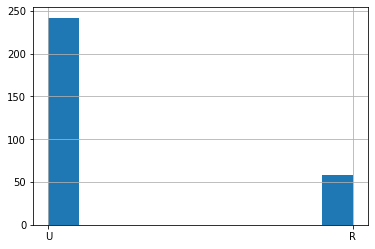

In [61]:
student = permitValidValue(student, 'address', ['U', 'R'])
student['address'].hist()

**famsize** — размер семьи('LE3' <= 3, 'GT3' >3)

<AxesSubplot:>

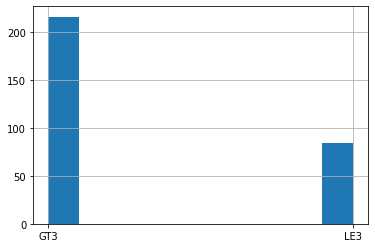

In [62]:
student = permitValidValue(student, 'famsize', ['LE3', 'GT3'])
student['famsize'].hist()

**Pstatus** - статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

<AxesSubplot:>

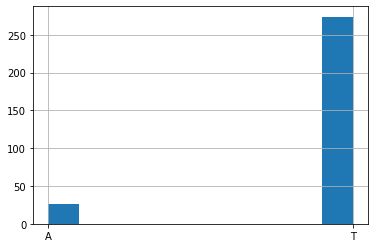

In [63]:
student = permitValidValue(student, 'Pstatus', ['T', 'A'])
student['Pstatus'].hist()

**Mjob** - работа матери

<AxesSubplot:>

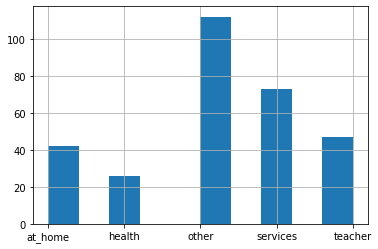

In [64]:
student = permitValidValue(student, 'Mjob', ['teacher', 'health', 'services', 'at_home', 'other'])
student['Mjob'].hist()

**Fjob**  - работа отца

<AxesSubplot:>

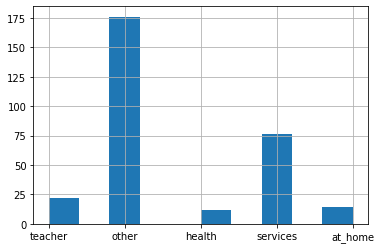

In [65]:
student = permitValidValue(student, 'Fjob', ['teacher', 'health', 'services', 'at_home', 'other'])
student['Fjob'].hist()

**reason**  — причина выбора школы

<AxesSubplot:>

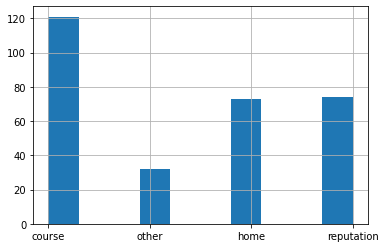

In [66]:
student = permitValidValue(student, 'reason', ['home', 'reputation', 'course', 'other'])
student['reason'].hist()

**guardian**  — опекун

<AxesSubplot:>

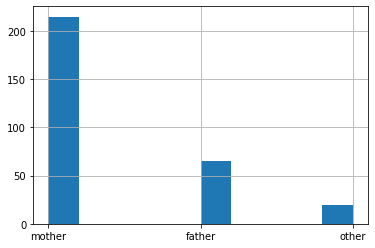

In [67]:
student = permitValidValue(student, 'guardian', ['mother', 'father', 'other'])
student['guardian'].hist()

**schoolsup** - дополнительная образовательная поддержка

<AxesSubplot:>

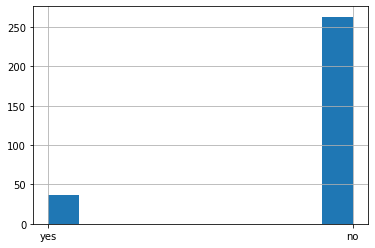

In [68]:
student = permitValidValue(student, 'schoolsup', ['yes', 'no'])
student['schoolsup'].hist()

**famsup** — семейная образовательная поддержка

<AxesSubplot:>

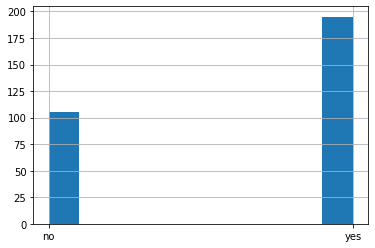

In [69]:
student = permitValidValue(student, 'famsup', ['yes', 'no'])
student['famsup'].hist()

**paid** — дополнительные платные занятия по математике

<AxesSubplot:>

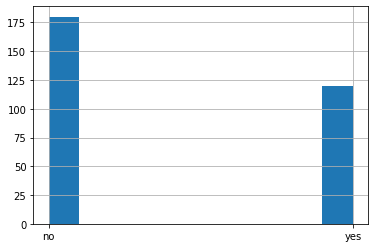

In [70]:
student = permitValidValue(student, 'paid', ['yes', 'no'])
student['paid'].hist()

**activities** — дополнительные внеучебные занятия

<AxesSubplot:>

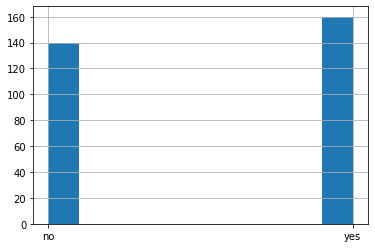

In [71]:
student = permitValidValue(student, 'activities', ['yes', 'no'])
student['activities'].hist()

**nursery** — посещал детский сад

<AxesSubplot:>

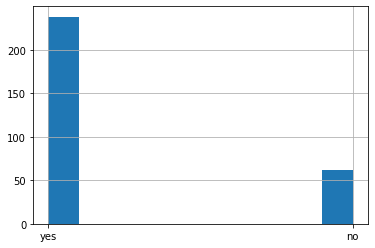

In [72]:
student = permitValidValue(student, 'nursery', ['yes', 'no'])
student['nursery'].hist()

**higher** — хочет получить высшее образование

<AxesSubplot:>

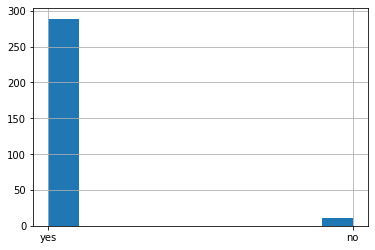

In [73]:
student = permitValidValue(student, 'higher', ['yes', 'no'])
student['higher'].hist()

**internet** — наличие интернета дома

<AxesSubplot:>

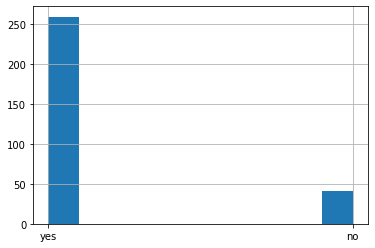

In [74]:
student = permitValidValue(student, 'internet', ['yes', 'no'])
student['internet'].hist()

**romantic** — в романтических отношениях

<AxesSubplot:>

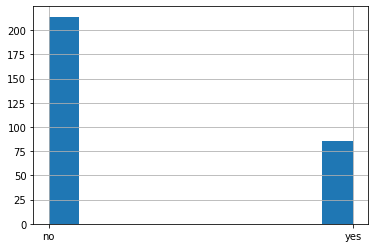

In [75]:
student = permitValidValue(student, 'romantic', ['yes', 'no'])
student['romantic'].hist()

## 3. Корреляционный анализ количественных переменных
Вывод сильно скорелированных значений

In [81]:
correlation = student.corr()
print(correlation)

                 age      Medu      Fedu  traveltime  studytime  failures  \
age         1.000000 -0.172434 -0.190000    0.151086   0.059275  0.299073   
Medu       -0.172434  1.000000  0.573589   -0.135582   0.111964 -0.220597   
Fedu       -0.190000  0.573589  1.000000   -0.070700   0.061183 -0.290370   
traveltime  0.151086 -0.135582 -0.070700    1.000000  -0.084657  0.049115   
studytime   0.059275  0.111964  0.061183   -0.084657   1.000000 -0.129888   
failures    0.299073 -0.220597 -0.290370    0.049115  -0.129888  1.000000   
granular    0.059275  0.111964  0.061183   -0.084657   1.000000 -0.129888   
famrel      0.041206  0.015949 -0.012997    0.007218   0.088594  0.028950   
freetime    0.035597  0.046158 -0.025900   -0.040156  -0.083086  0.124606   
goout       0.184732  0.080240  0.011790   -0.022640   0.013071  0.098215   
health     -0.050860 -0.032696  0.006666   -0.027381  -0.029396  0.052857   
absences    0.216430  0.024759 -0.083551   -0.035630  -0.113282  0.223426   

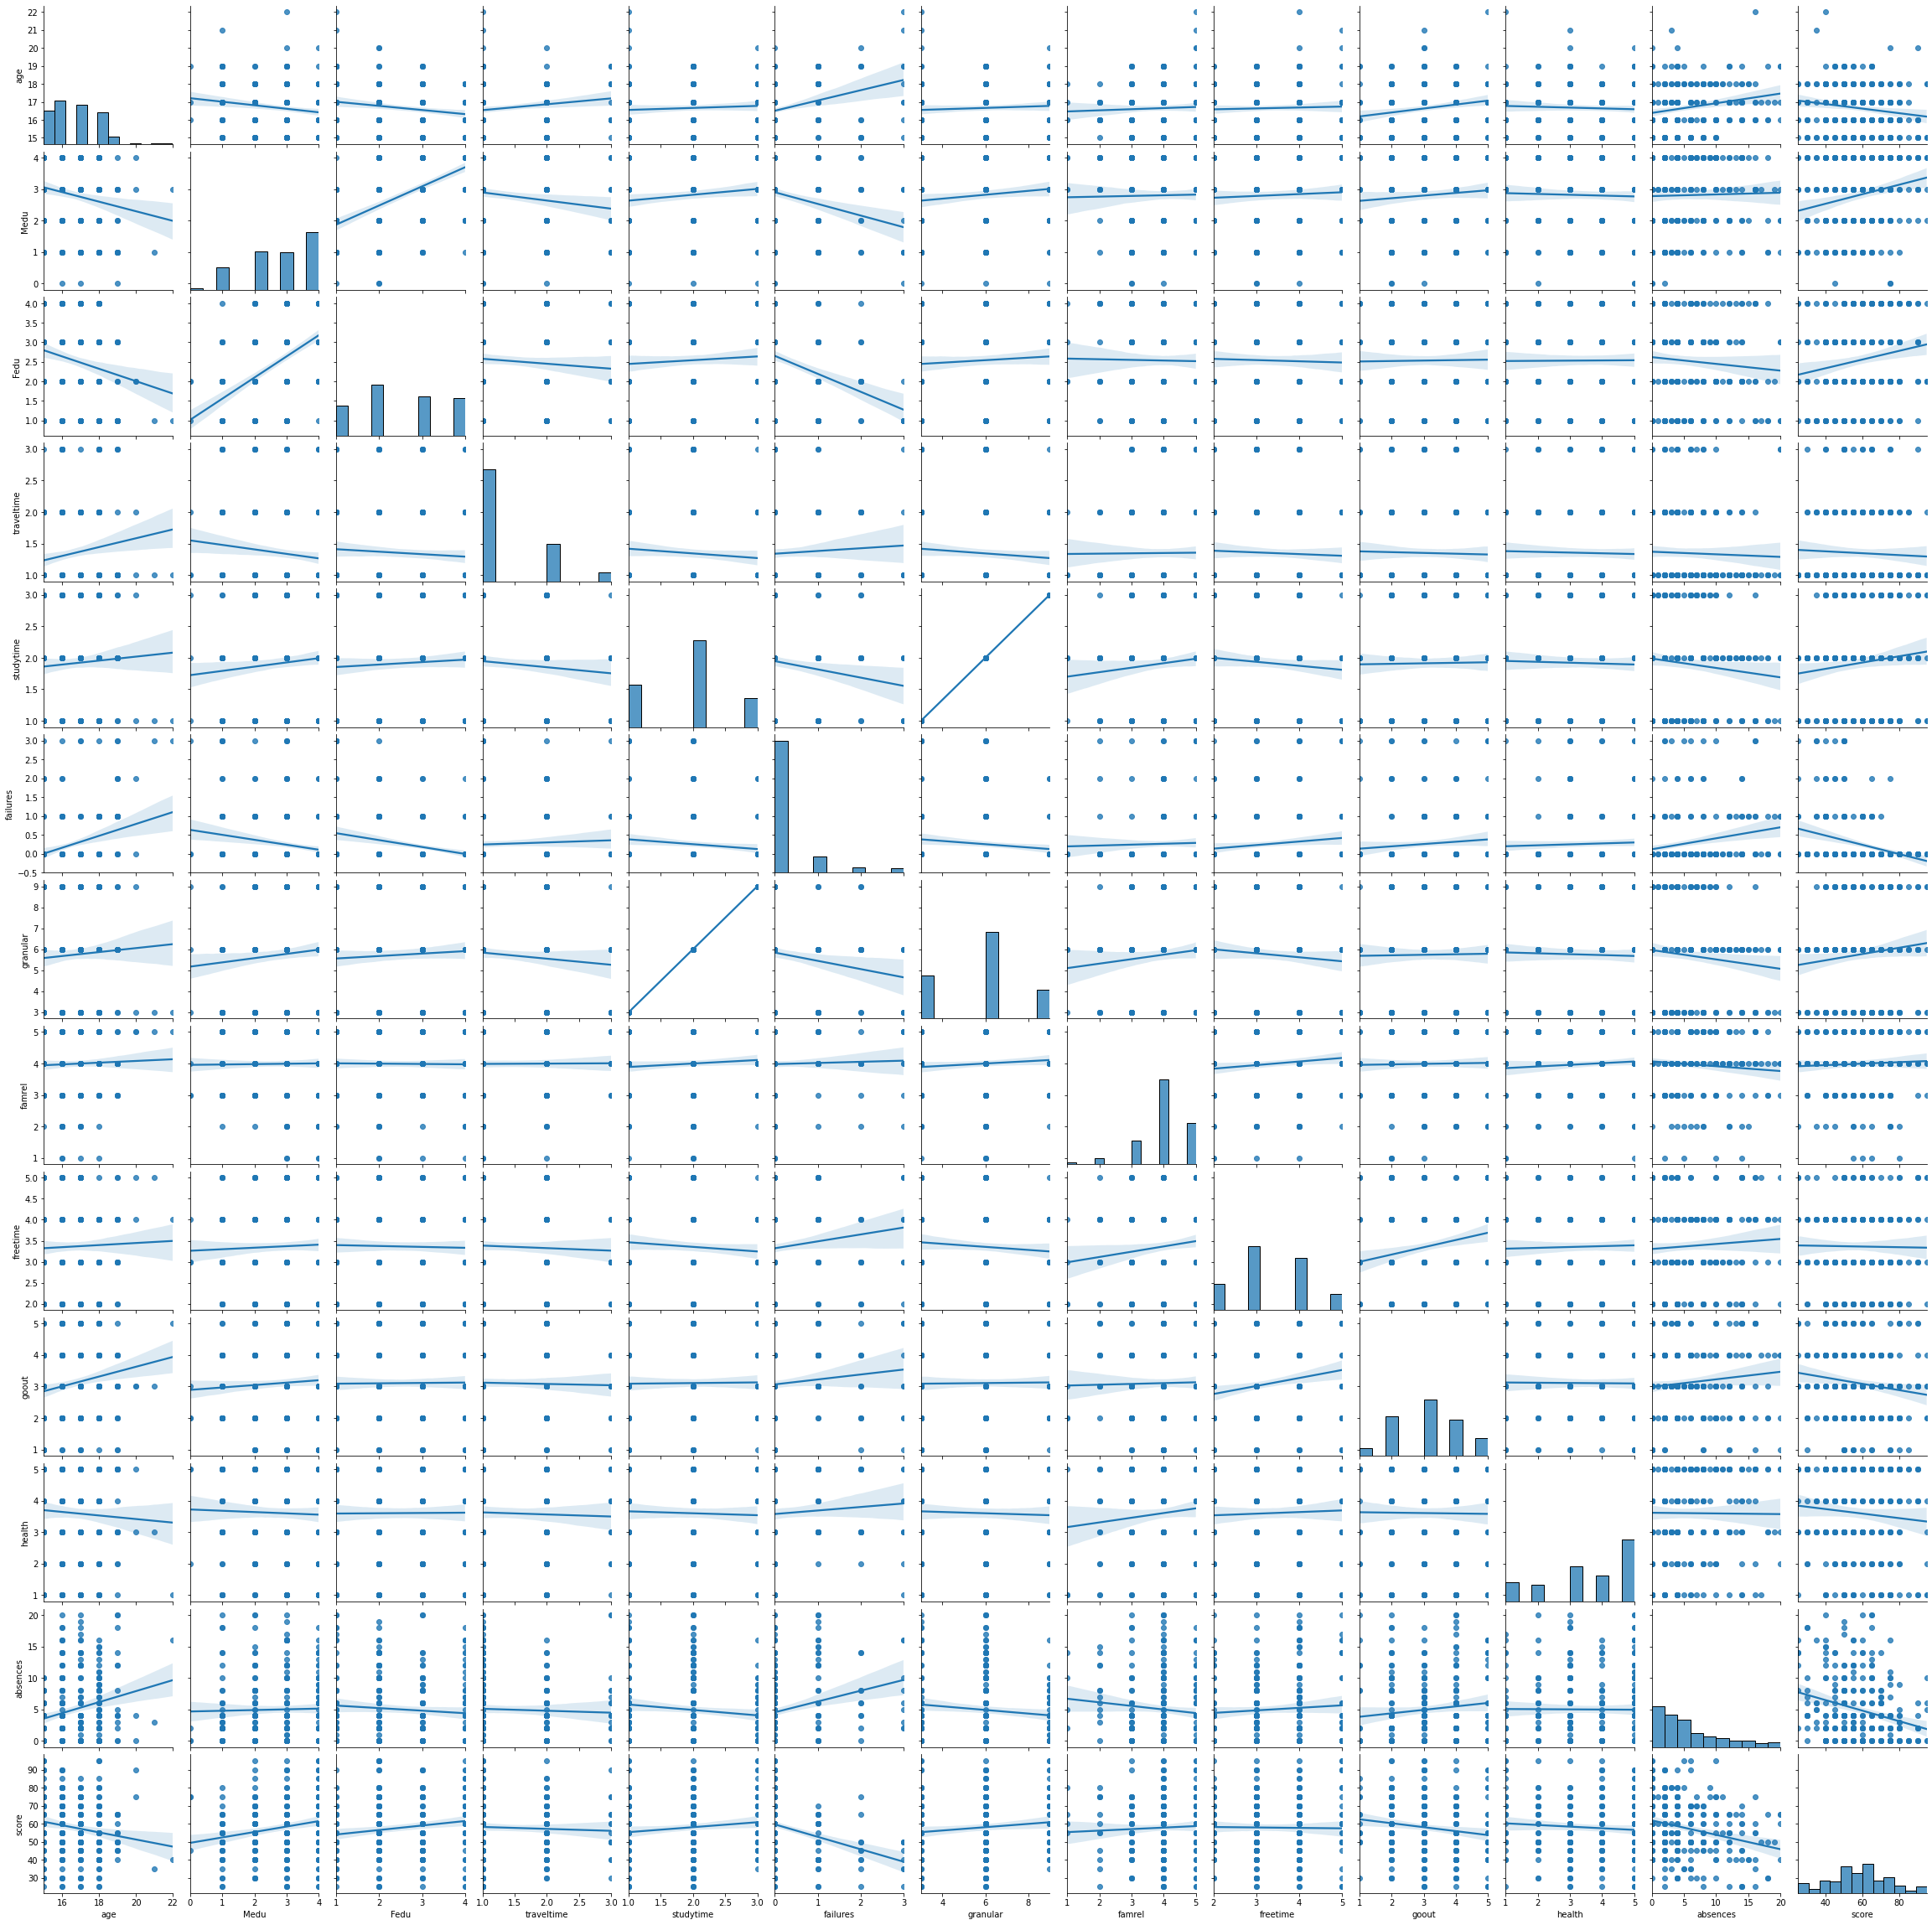

In [83]:
sns.pairplot(student, kind = 'reg')

In [79]:
print(correlation[(correlation >= 0.4) | (correlation <= -0.4)])

            age      Medu      Fedu  traveltime  studytime  failures  \
age         1.0       NaN       NaN         NaN        NaN       NaN   
Medu        NaN  1.000000  0.573589         NaN        NaN       NaN   
Fedu        NaN  0.573589  1.000000         NaN        NaN       NaN   
traveltime  NaN       NaN       NaN         1.0        NaN       NaN   
studytime   NaN       NaN       NaN         NaN        1.0       NaN   
failures    NaN       NaN       NaN         NaN        NaN       1.0   
granular    NaN       NaN       NaN         NaN        1.0       NaN   
famrel      NaN       NaN       NaN         NaN        NaN       NaN   
freetime    NaN       NaN       NaN         NaN        NaN       NaN   
goout       NaN       NaN       NaN         NaN        NaN       NaN   
health      NaN       NaN       NaN         NaN        NaN       NaN   
absences    NaN       NaN       NaN         NaN        NaN       NaN   
score       NaN       NaN       NaN         NaN        NaN      

**Выводы** на основе корреляционного анализа количественных переменных:
- неизвестный параметр granular  полностью коррелируется с studytime (studytime - предварительно убираем с выборки)
- образование отца и матери коорелируется тоже, из этого можно сделать выход что семьи создаются в том числе и на основе 
уровня образованности родителей

## 4. Анализ номинативных переменных

Так как числовые показатели по факту являются и номитативными переменными, только выраженными цифрами, они тоже будут учавствовать в расчете

In [84]:
def get_boxplot(date, column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='score',
                data=date.loc[:],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

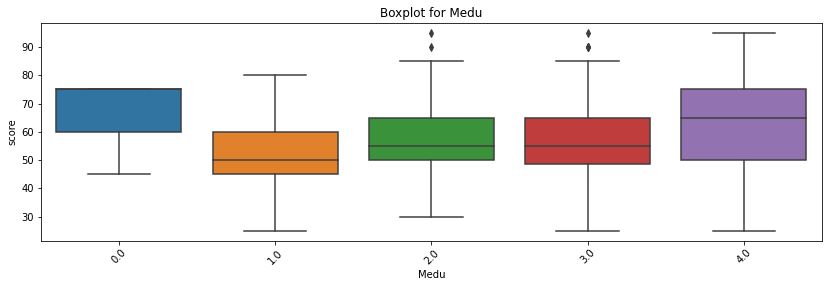

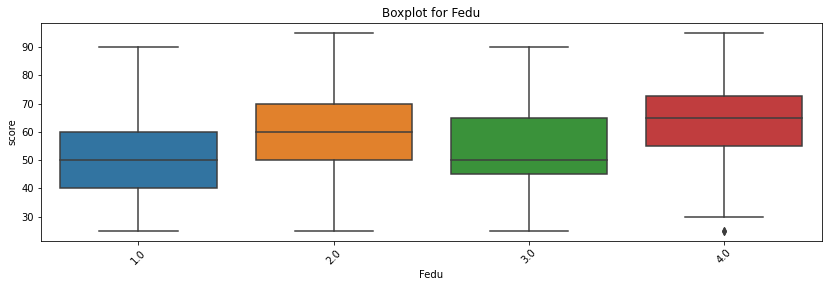

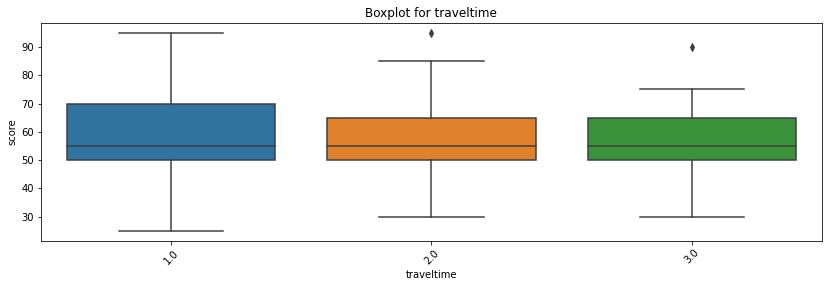

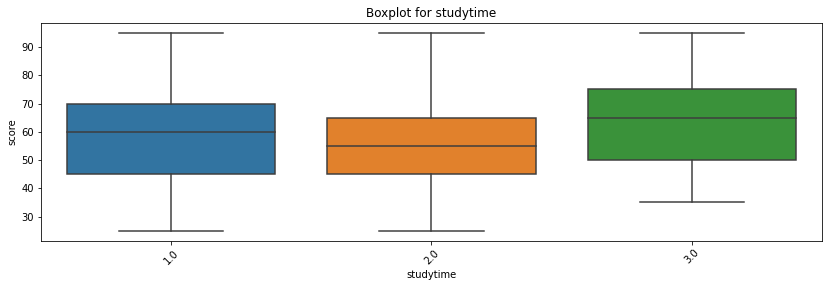

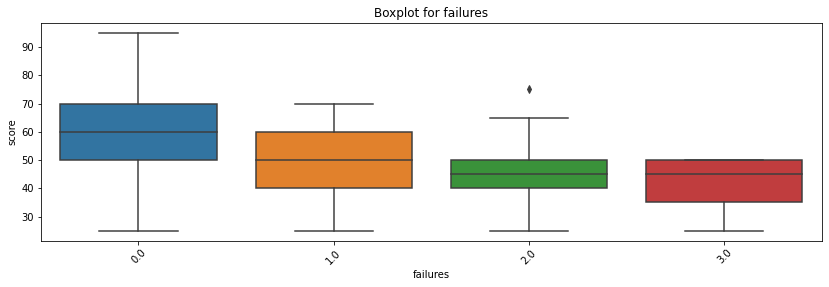

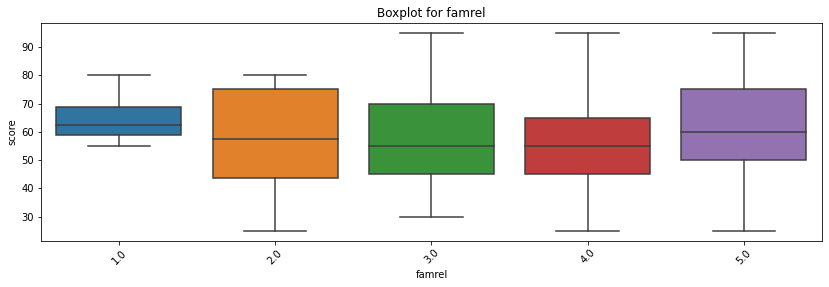

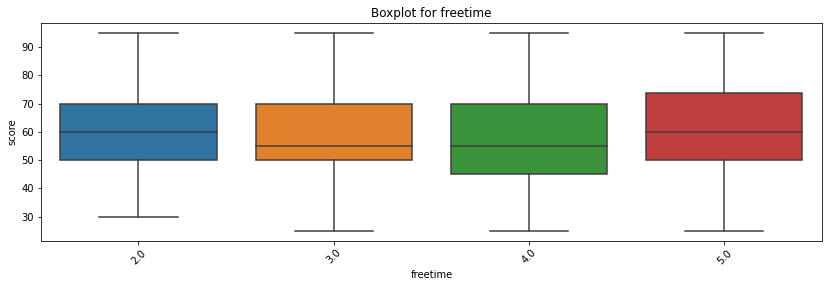

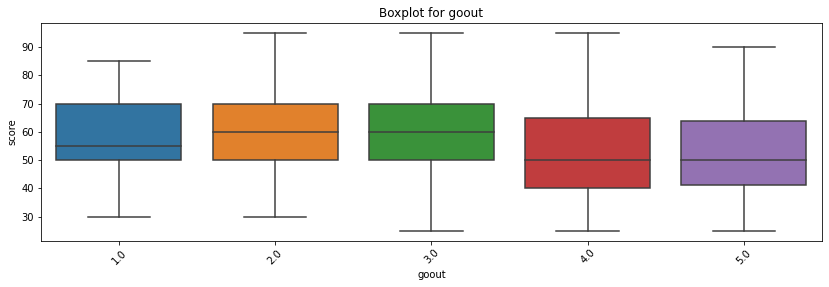

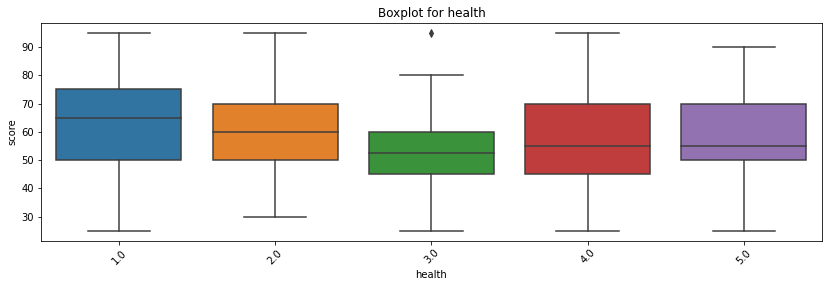

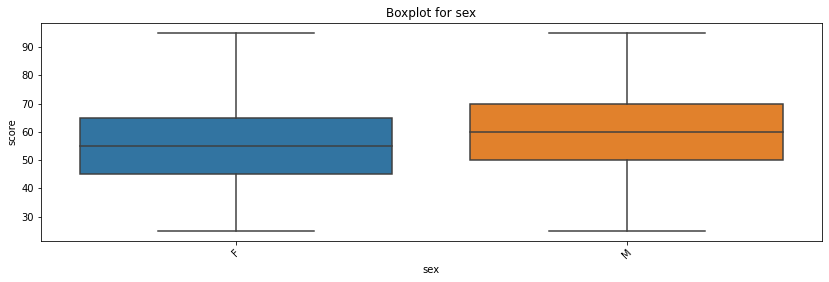

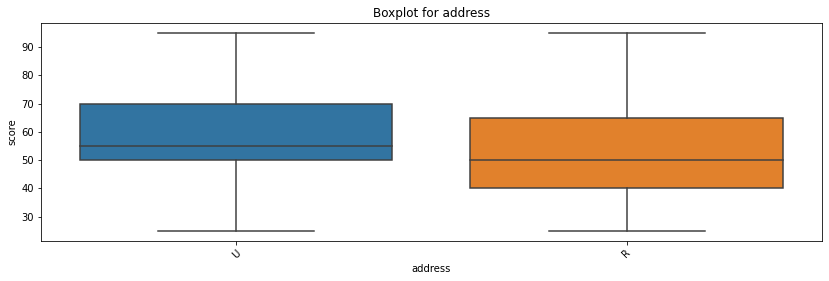

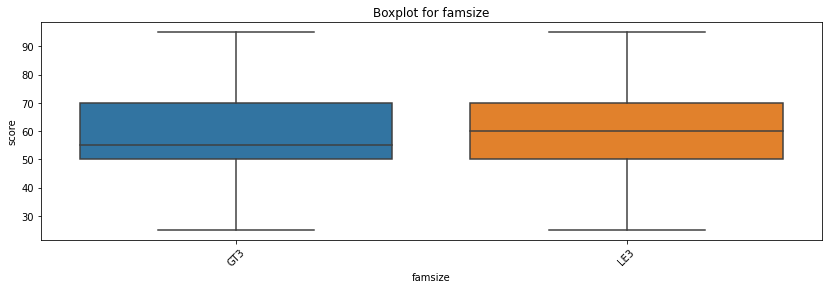

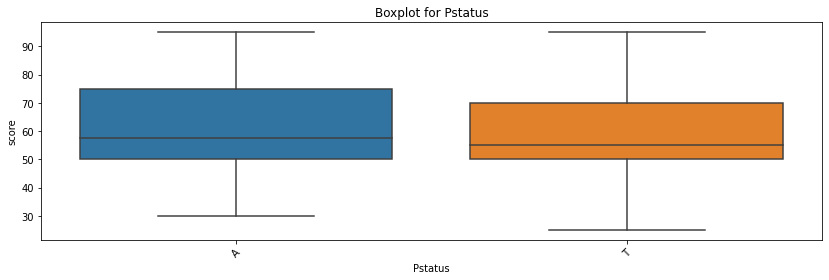

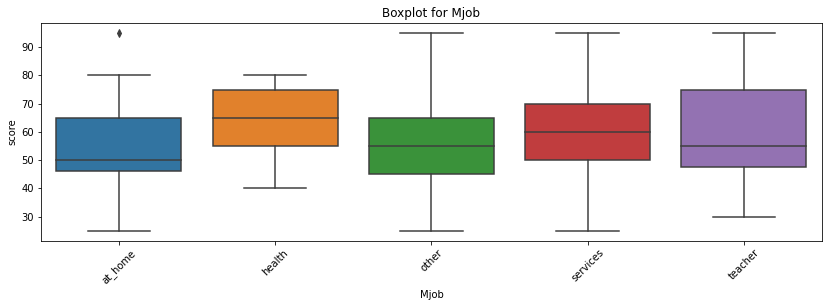

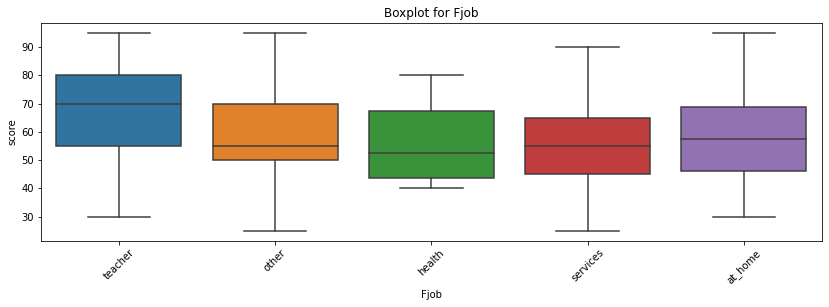

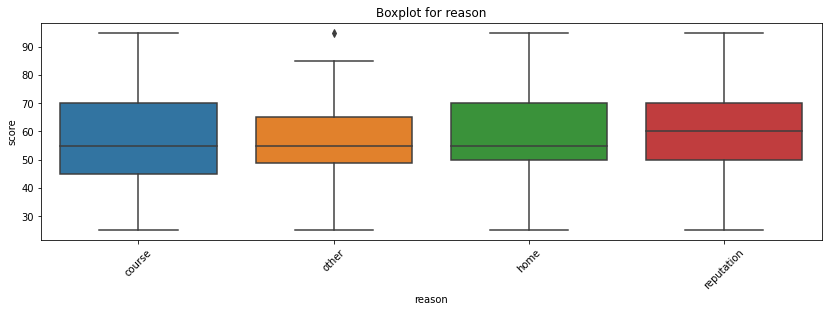

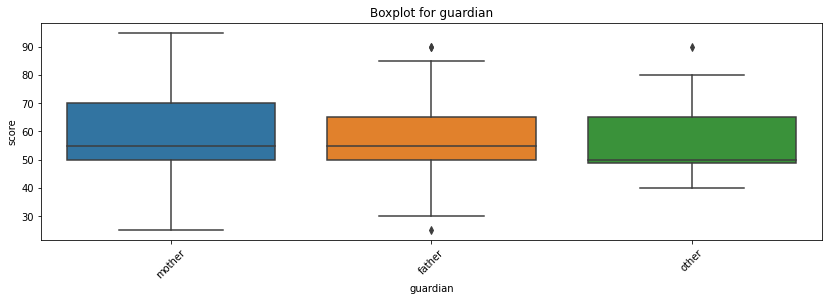

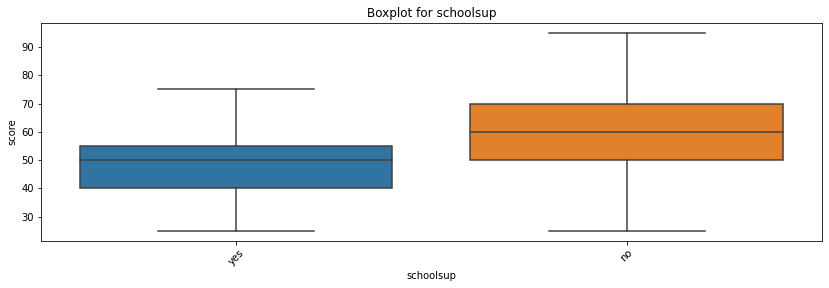

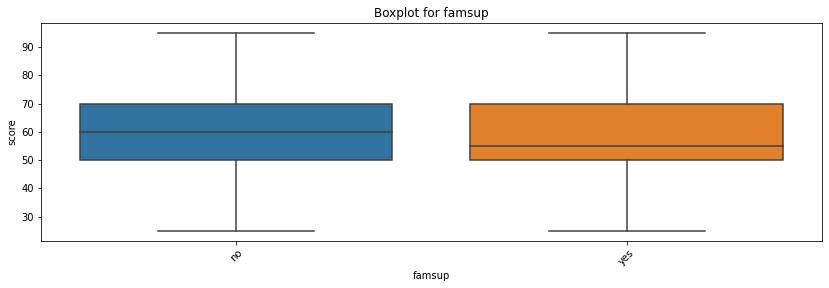

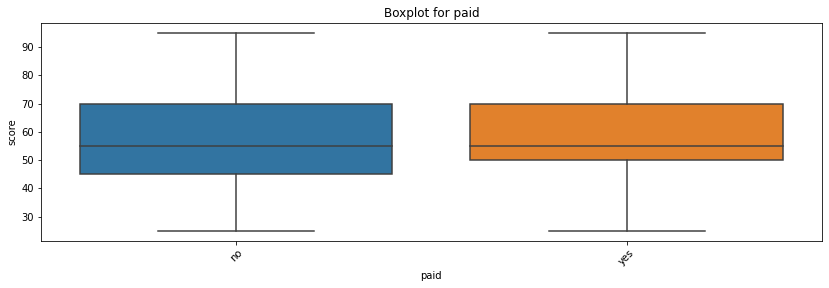

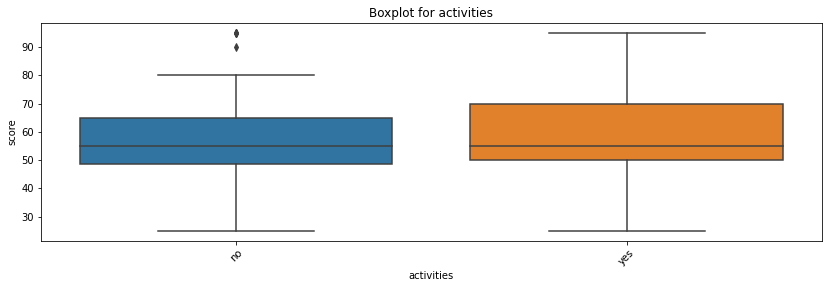

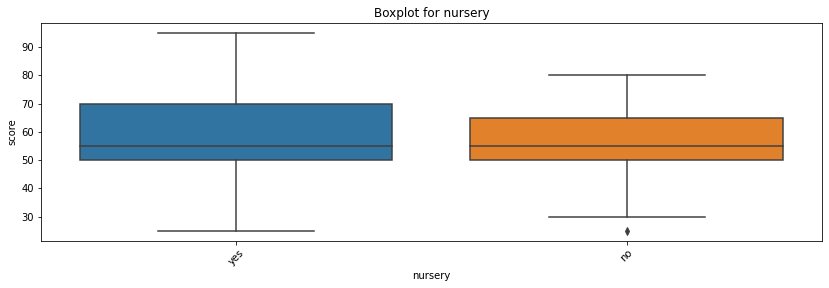

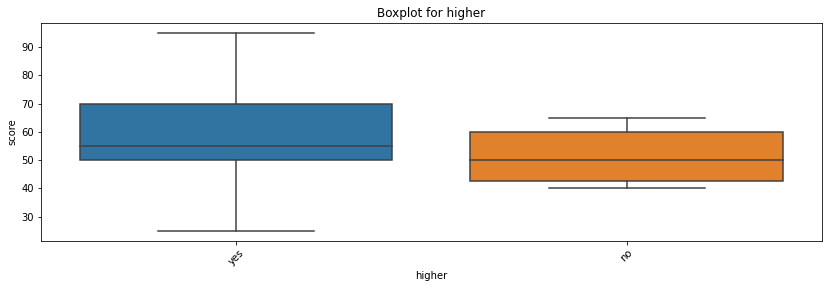

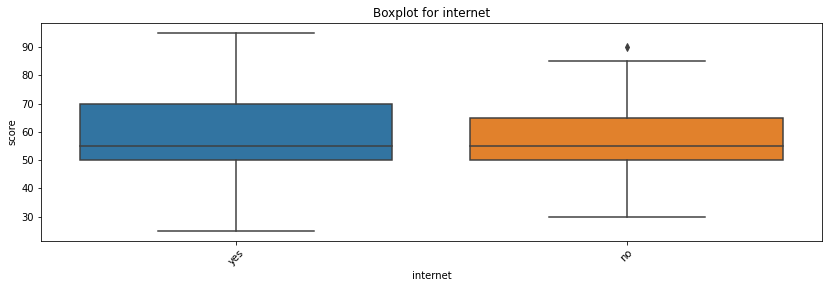

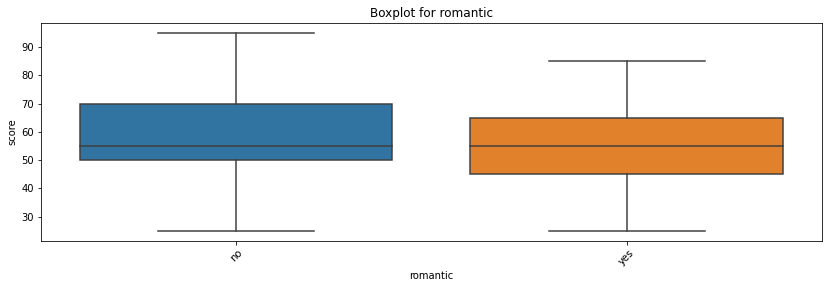

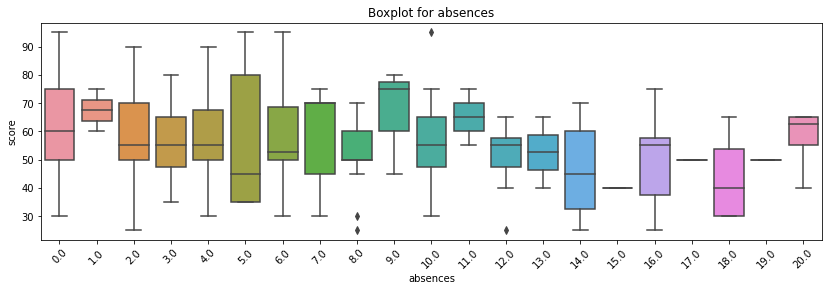

In [87]:
for col in ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'health',
            'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian',
            'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet',
            'romantic', 'absences']:
    get_boxplot(student, col)

**Выводы:**
Образование матери -  высшее и отсуствие образования среднем дает более высокий баллы 

Образование отца -  отсуствие образования дает наименьший баллы, все остальное одинаково

Время в пути до школы  - не влияет на баллы

Время на учёбу помимо школы - сказываетя на баллы только если тратить болье 5 - 10 часов

Количество внеучебных неуда - чем меньше неудач тем больше быллы

Семейные отношения - не влияют на баллы

свободное время после школы  - не влияют на баллы

проведение времени с друзьями -  чем меньше времени тем лучше баллы

текущее состояние здоровья - среднее здоровье показывает наименьшие баллы

Пол  - у мужчин больще баллов

тип адреса ученика  - городские показывают лучше баллы

размер семьи - не влияет на баллы

Статус совместного жилья родителей - раздельное проживание показывает больше баллы чем совместное

Работа матери - сфера здравоохранения показывает лучший результат, остальные примерно одинаковы

Работа отца - учитель показывает лучший результат, остальные примерно одинаковы

Причина выбора школы - не влияет на баллы

опекун  -  не влияет на баллы

дополнительная образовательная поддержка - при ее отсутствии баллы выше

семейная образовательная поддержка -  не влияет на баллы

дополнительные платные занятия по математи - при присутвии балыы немного выше 

дополнительные внеучебные занятия  - не влияет на баллы

посещение детского сада - при ее присутвии баллы выше

хочет получить высшее образовани - при ее присутвии баллы выше

наличие интернета дома - не влияет на баллы

в романтических отношениях  - не влияет на баллы

количество пропущенных занятий - мало данных для анализа


## 5 Статистический анализ  равенства средних величин

In [88]:
def get_stat_dif(date, column):
    cols = date.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(date.loc[date.loc[:, column] == comb[0], 'score'],
                     date.loc[date.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05 / len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [89]:
for col in ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'health',
            'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian',
            'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet',
            'romantic', 'absences']:
    get_stat_dif(student, col)

Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки Fedu
Найдены статистически значимые различия для колонки studytime
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки health
Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Fjob
Найдены статистически значимые различия для колонки schoolsup
